In [6]:
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

mnist = tf.keras.datasets.mnist
to_categorical = tf.keras.utils.to_categorical
Sequential = tf.keras.models.Sequential
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

In [7]:
# Load dataset

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess dataset
train_images: np.ndarray = train_images.reshape((60000, 28*28, 1)).astype('float32') / 255
test_images: np.ndarray = test_images.reshape((10000, 28*28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [8]:
def create_model():
    model = Sequential()
    model.add(Dense(784, activation='relu', input_shape=(28*28,)))  # One neuron per pixel
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_model_faster():
    """
    This model should yield better results as we use MaxPooling2D which makes us overfit less over the images
    However the point of notebook is not to make a good model but to compare model performance differences
    Across cpu and gpu devices
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Function to train model and measure time
def train_model(device):
    with tf.device(device):
        model = create_model()
        start_time = time.time()
        model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.3)
        end_time = time.time()
    return model, end_time - start_time

# Train on CPU
cpu_model, cpu_time = train_model('/CPU:0')
print(f'Training time on CPU: {cpu_time} seconds')

# Train on GPU
if tf.config.list_physical_devices('GPU'):
    gpu_model, gpu_time = train_model('/GPU:0')
    print(f'Training time on GPU: {gpu_time} seconds')
else:
    print('No GPU found.')


Epoch 1/10
657/657 [==============================] - 12s 18ms/step - loss: 1.6614 - accuracy: 0.3358 - val_loss: 0.9980 - val_accuracy: 0.5484
Epoch 2/10
657/657 [==============================] - 12s 19ms/step - loss: 0.9562 - accuracy: 0.6221 - val_loss: 0.5474 - val_accuracy: 0.8288
Epoch 3/10
657/657 [==============================] - 12s 19ms/step - loss: 0.5677 - accuracy: 0.8054 - val_loss: 0.4086 - val_accuracy: 0.8429
Epoch 4/10
657/657 [==============================] - 12s 19ms/step - loss: 0.4391 - accuracy: 0.8550 - val_loss: 0.3240 - val_accuracy: 0.8994
Epoch 5/10
657/657 [==============================] - 13s 19ms/step - loss: 0.3238 - accuracy: 0.9213 - val_loss: 0.2509 - val_accuracy: 0.9364
Epoch 6/10
657/657 [==============================] - 13s 19ms/step - loss: 0.2627 - accuracy: 0.9435 - val_loss: 0.2121 - val_accuracy: 0.9539
Epoch 7/10
657/657 [==============================] - 13s 19ms/step - loss: 0.2112 - accuracy: 0.9559 - val_loss: 0.2074 - val_accuracy:

CPU Model Predictions:
313/313 [==============================] - 1s 2ms/step
First 5 Correct Predictions:


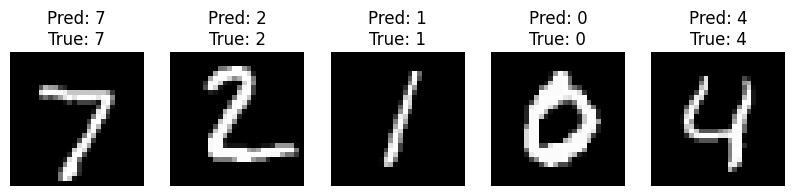

First 5 Incorrect Predictions:


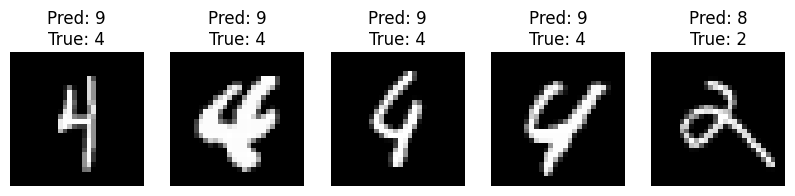

GPU Model Predictions:
313/313 [==============================] - 0s 838us/step
First 5 Correct Predictions:


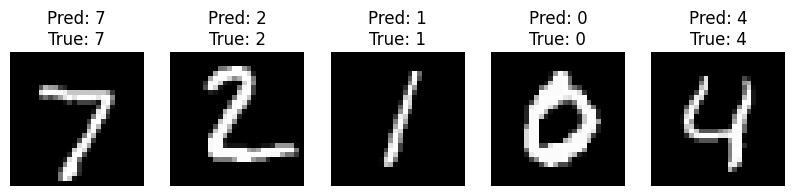

First 5 Incorrect Predictions:


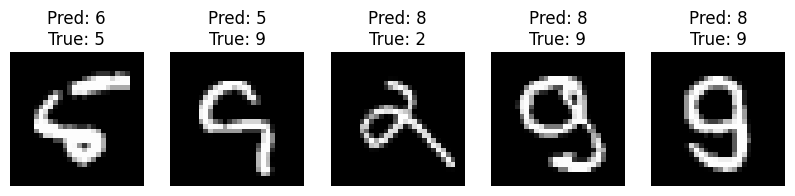

In [10]:
def display_predictions(model):
    # Predict on test images
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Identify correctly and incorrectly classified images
    correct_indices = np.where(predicted_labels == true_labels)[0]
    incorrect_indices = np.where(predicted_labels != true_labels)[0]

    # Display first 5 correct predictions
    print("First 5 Correct Predictions:")
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(correct_indices[:5]):
        plt.subplot(1, 5, i + 1)
        plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {predicted_labels[idx]}\nTrue: {true_labels[idx]}")
        plt.axis('off')
    plt.show()

    # Display first 5 incorrect predictions
    print("First 5 Incorrect Predictions:")
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(incorrect_indices[:5]):
        plt.subplot(1, 5, i + 1)
        plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {predicted_labels[idx]}\nTrue: {true_labels[idx]}")
        plt.axis('off')
    plt.show()

# Display predictions for CPU model
print("CPU Model Predictions:")
display_predictions(cpu_model)

# Display predictions for GPU model (if available)
if tf.config.list_physical_devices('GPU'):
    print("GPU Model Predictions:")
    display_predictions(gpu_model)